In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import cartopy.io.shapereader as shpreader
import metpy
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc

from metpy.plots import SkewT
from metpy.plots import Hodograph
from metpy.calc import lcl
from metpy.calc import dewpoint_from_relative_humidity, lfc
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colorbar, colors

In [8]:
mes = "junho2022"
local ="Palhoça"
n = 13

In [5]:
t_data = xr.open_dataset(f'./dados2/{mes}.nc', engine="netcdf4")
lt_data = xr.open_dataset(f'./dados2/l{mes}.nc', engine="netcdf4")

In [9]:
lt_data.time[n]

<xarray.DataArray 'time' ()>
array('2022-06-21T13:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-06-21T13:00:00
Attributes:
    long_name:  time

In [25]:
lt_data.latitude[11]


<xarray.DataArray 'latitude' ()>
array(-27.75, dtype=float32)
Coordinates:
    latitude  float32 -27.75
Attributes:
    units:      degrees_north
    long_name:  latitude

In [26]:

lo = 21
la = 11

gelo = t_data.deg0l[n,:] #data e hora ver no xarray acima
cape = t_data.cape[n,:]

lat = t_data.latitude
lon = t_data.longitude

llat = lt_data.latitude
llon = lt_data.longitude

mucapee = []
pw = []
lift = []
k = []
tvvt = []
tempo = []

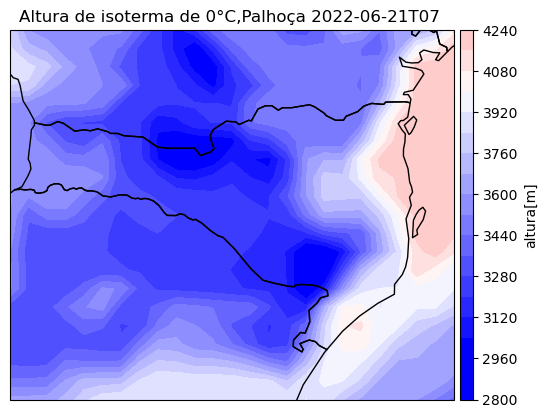

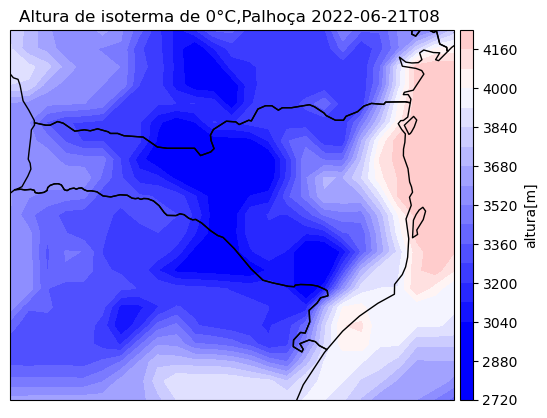

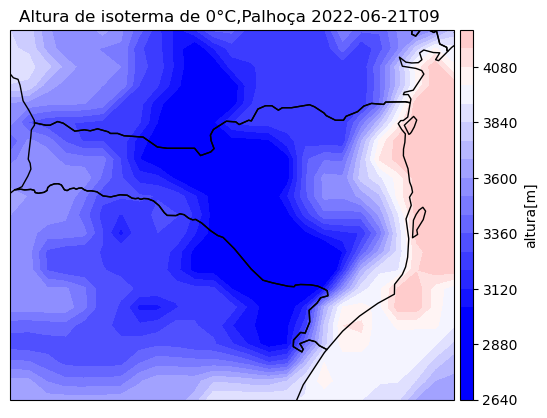

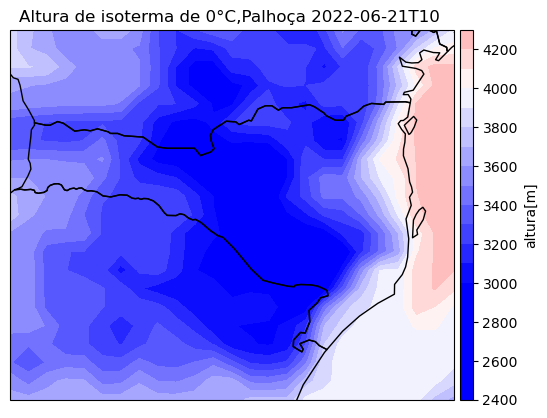

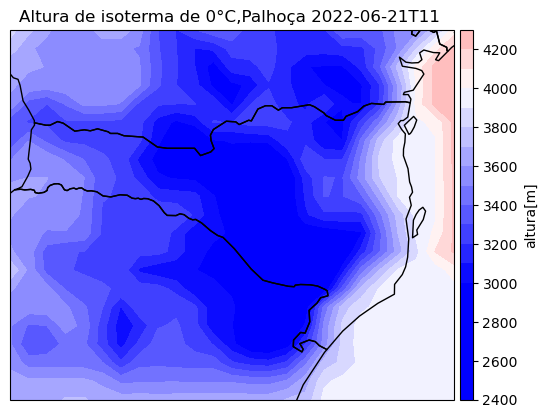

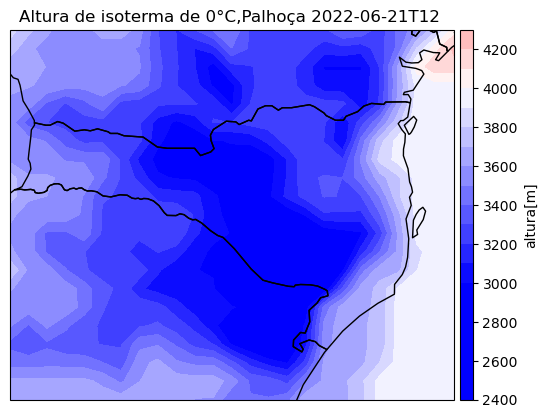

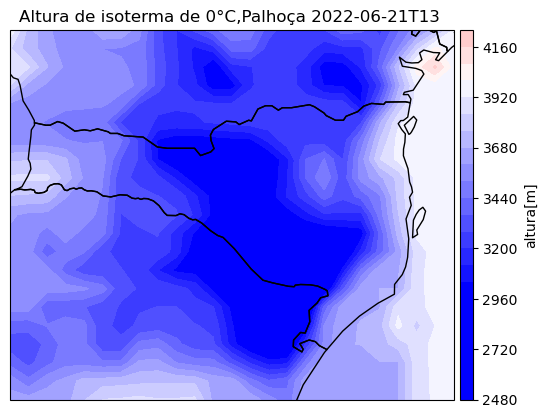

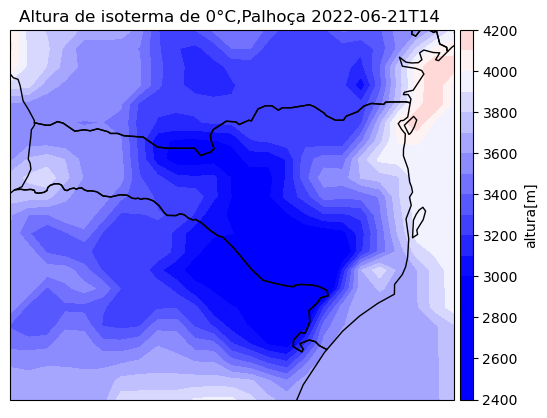

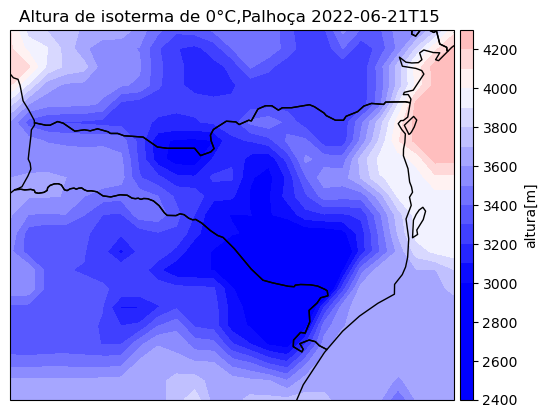

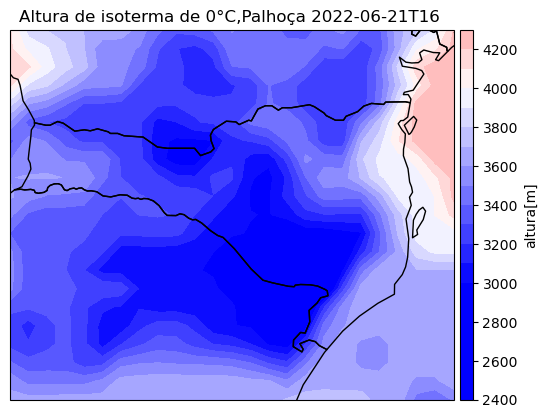

In [27]:
# Setup the figure

d = n-6
while d < n+4:
    gelo = t_data.deg0l[d,:]
    hora = t_data.time[d].values
    hora = str(hora)
    hora = hora[0:13]

    fig = plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree())
    plt.title(f"Altura de isoterma de 0°C,{local} {hora} ")

    tplot = ax.contourf(lon, lat, gelo, cmap='bwr', levels=20, vmin=3000, vmax=5000)

    posn = ax.get_position()
    cbar_ax = fig.add_axes([posn.x0 + posn.width + 0.01, posn.y0, 0.02, posn.height])

    plt.colorbar(tplot, cax=cbar_ax, label='altura[m]')
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\altura{d}.png', bbox_inches='tight')
    d+=1 

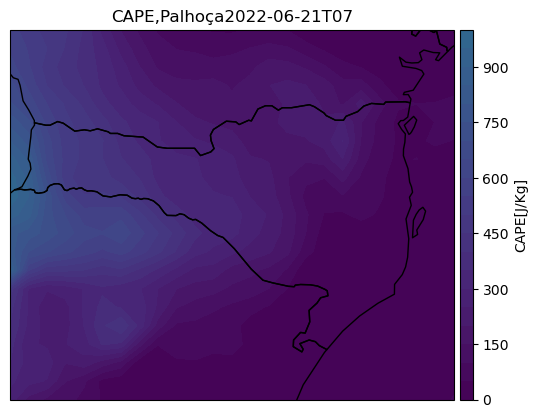

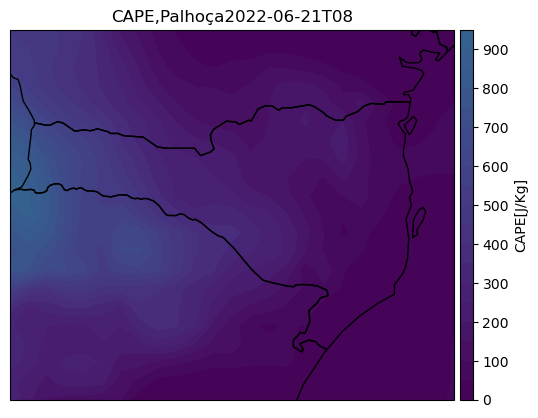

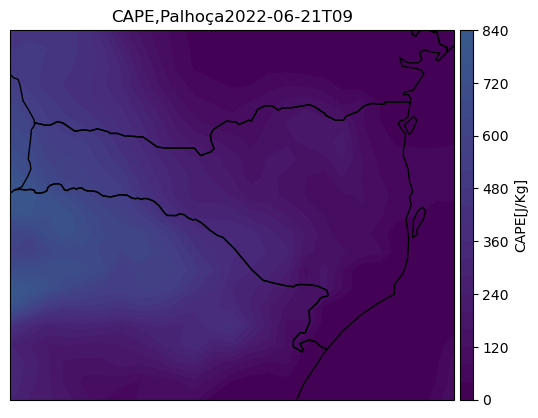

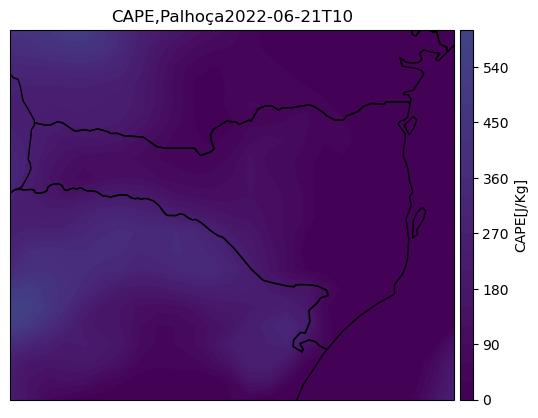

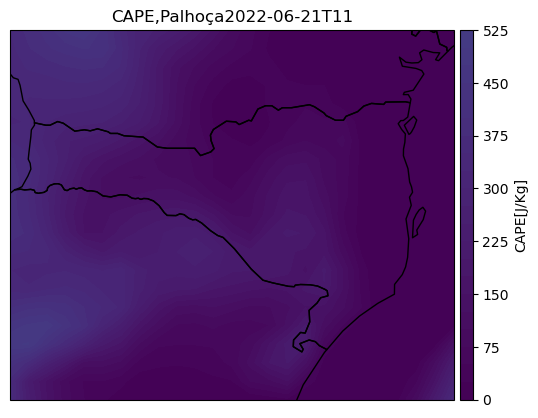

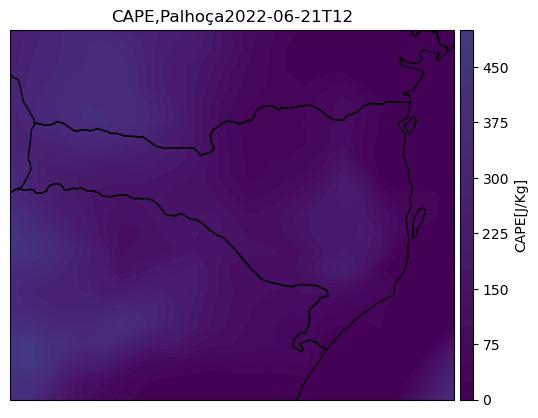

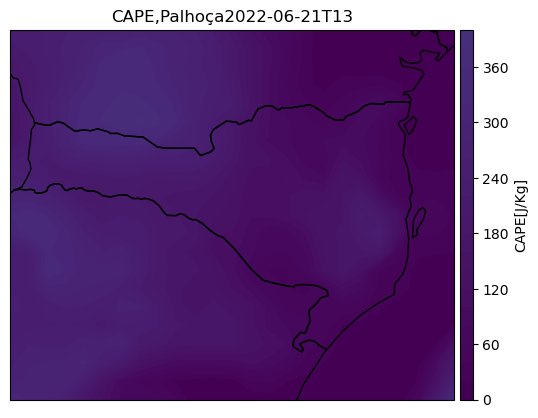

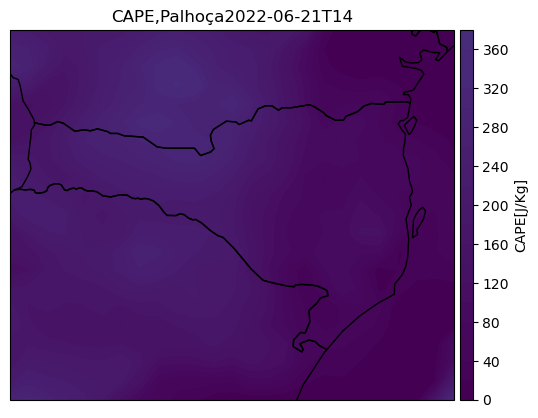

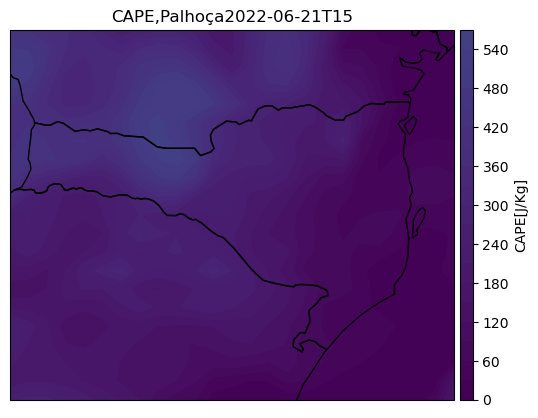

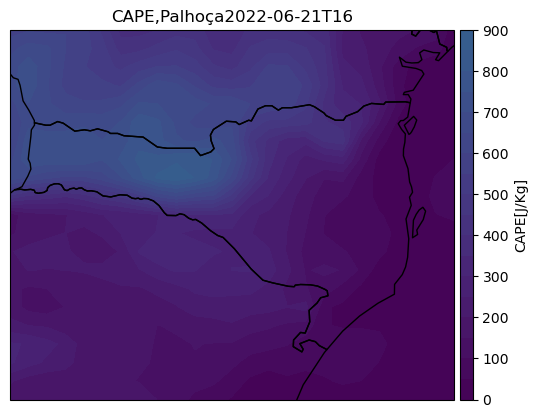

In [28]:
d = n-6
while d < n+4:
    cape = t_data.cape[d,:]
    hora = t_data.time[d].values
    hora = str(hora)
    hora = hora[0:13]
    
    fig = plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree())
    plt.title(f"CAPE,{local}{hora}")

    tplot = ax.contourf(lon, lat, cape, cmap='viridis', levels=20, vmin=0, vmax=3000 )

    posn = ax.get_position()
    cbar_ax = fig.add_axes([posn.x0 + posn.width + 0.01, posn.y0, 0.02, posn.height])

    plt.colorbar(tplot, cax=cbar_ax, label='CAPE[J/Kg]')

    ax.add_feature(cfeature.STATES.with_scale('50m'))
    fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\cape{d}.png', bbox_inches='tight')
    d+=1 

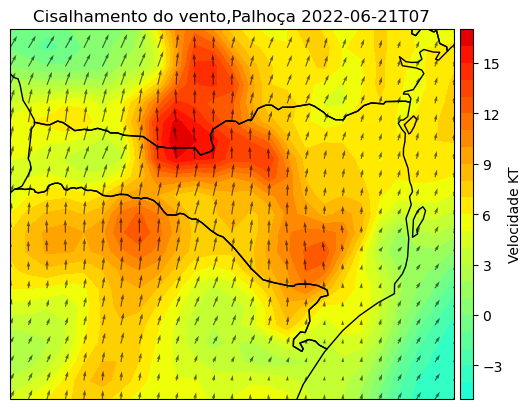

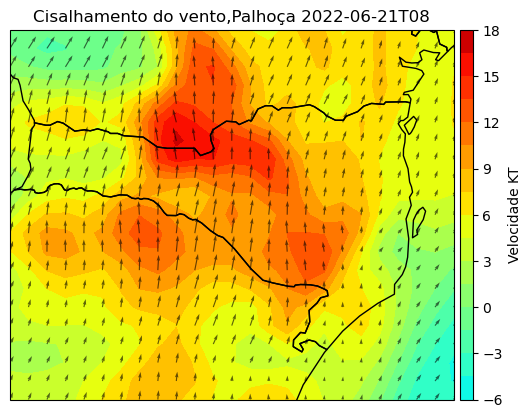

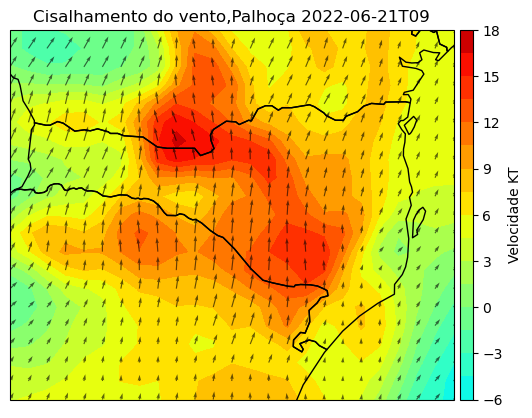

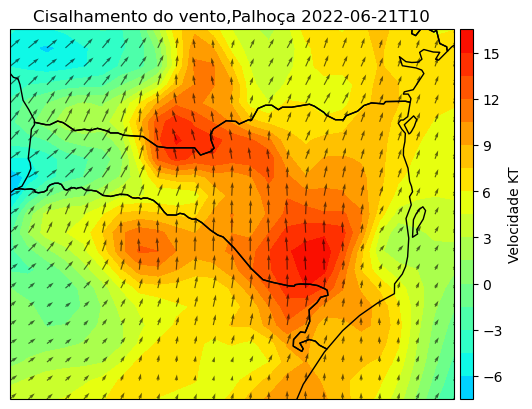

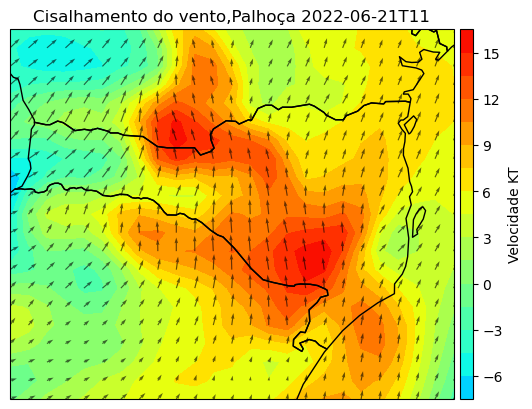

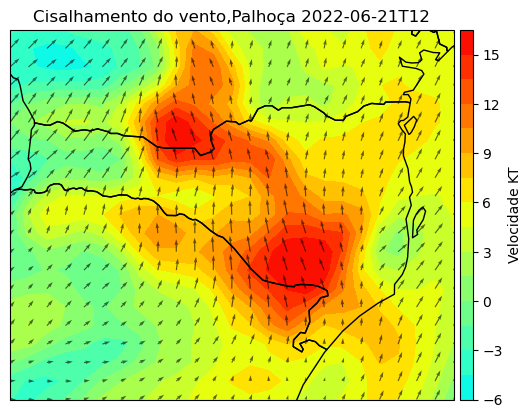

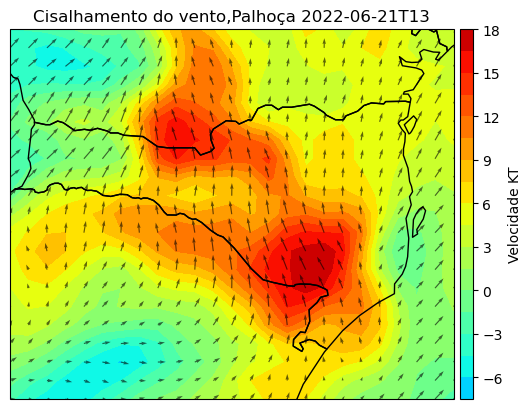

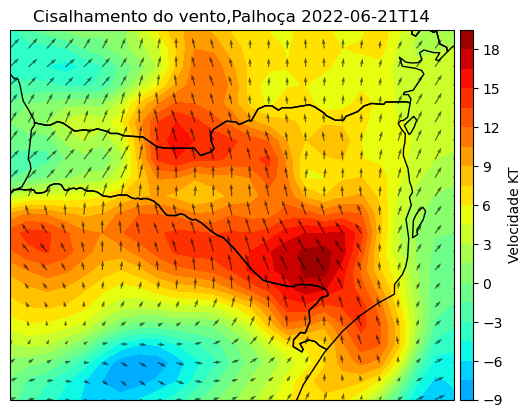

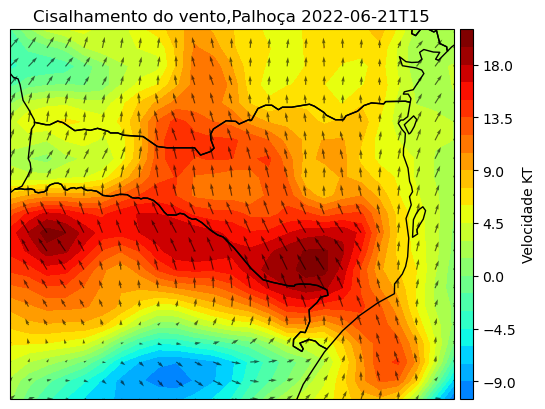

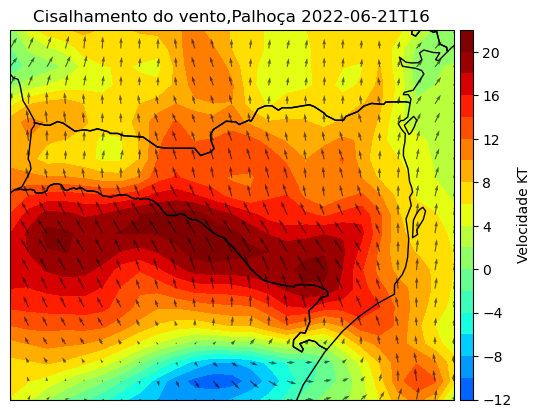

In [29]:
d = n-6
while d < n+4:
    ventinhov =  lt_data.v[d,32,:]
    ventinhou =  lt_data.u[d,32,:]
    ventov =  lt_data.v[d,24,:]
    ventou =  lt_data.u[d,24,:]
    
    hora = lt_data.time[d].values
    hora = str(hora)
    hora = hora[0:13]

    vento1000 = np.sqrt(ventinhov**2+ventinhou**2)
    vento500 = np.sqrt(ventou**2+ventov**2)
    
    fig = plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree())
    plt.title(f"Cisalhamento do vento,{local} {hora}")

    tplot = plt.contourf(llon,llat,vento500-vento1000,cmap=plt.cm.jet, levels=20, vmin=-20, vmax=20)
    plt.quiver(llon,llat,ventov-ventinhov,ventou-ventinhou,alpha=0.6);

    posn = ax.get_position()
    cbar_ax = fig.add_axes([posn.x0 + posn.width + 0.01, posn.y0, 0.02, posn.height])

    plt.colorbar(tplot, cax=cbar_ax, label='Velocidade KT')

    ax.add_feature(cfeature.STATES.with_scale('50m'))
    fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\cisalhamento{d}.png', bbox_inches='tight')
    d+=1 

In [30]:
d = n-6
while d <= n+3:
    t = (lt_data.t[d,:,la,lo].values-273.15)
    r = (lt_data.r[d,:,la,lo].values)
    td = t - ((100 - r)/5) 
    p = lt_data.level.values 
    u = (lt_data.u[d,:,la,lo].values*1.944)
    v = (lt_data.v[d,:,la,lo].values*1.944)
    tempo.append(lt_data.time[d].dt.strftime('%H:%M').values)
    z  = (lt_data.z[d,:,la,lo].values/9.80665)
    
    z = list(reversed(z)) * units.meters
    r = list(reversed(r)) *units.percent
    p = list(reversed(p)) * units.hPa
    t = list(reversed(t)) * units.degC
    td = list(reversed(td)) * units.degC
    u = list(reversed(u)) * units.knots
    v = list(reversed(v)) * units.knots 
    
    prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
    
    tvvt.append((t[0].magnitude - t[6].magnitude)/(z[0].magnitude-z[6].magnitude)+((t[6].magnitude - t[20].magnitude) /(z[6].magnitude-z[20].magnitude))/2)
    mucapee.append(mpcalc.most_unstable_cape_cin(p, t, td))
    pw.append(mpcalc.precipitable_water(p, td).magnitude) 
    lift.append(mpcalc.lifted_index(p, t, prof))
    d = d+1

ValueError: cannot convert float NaN to integer

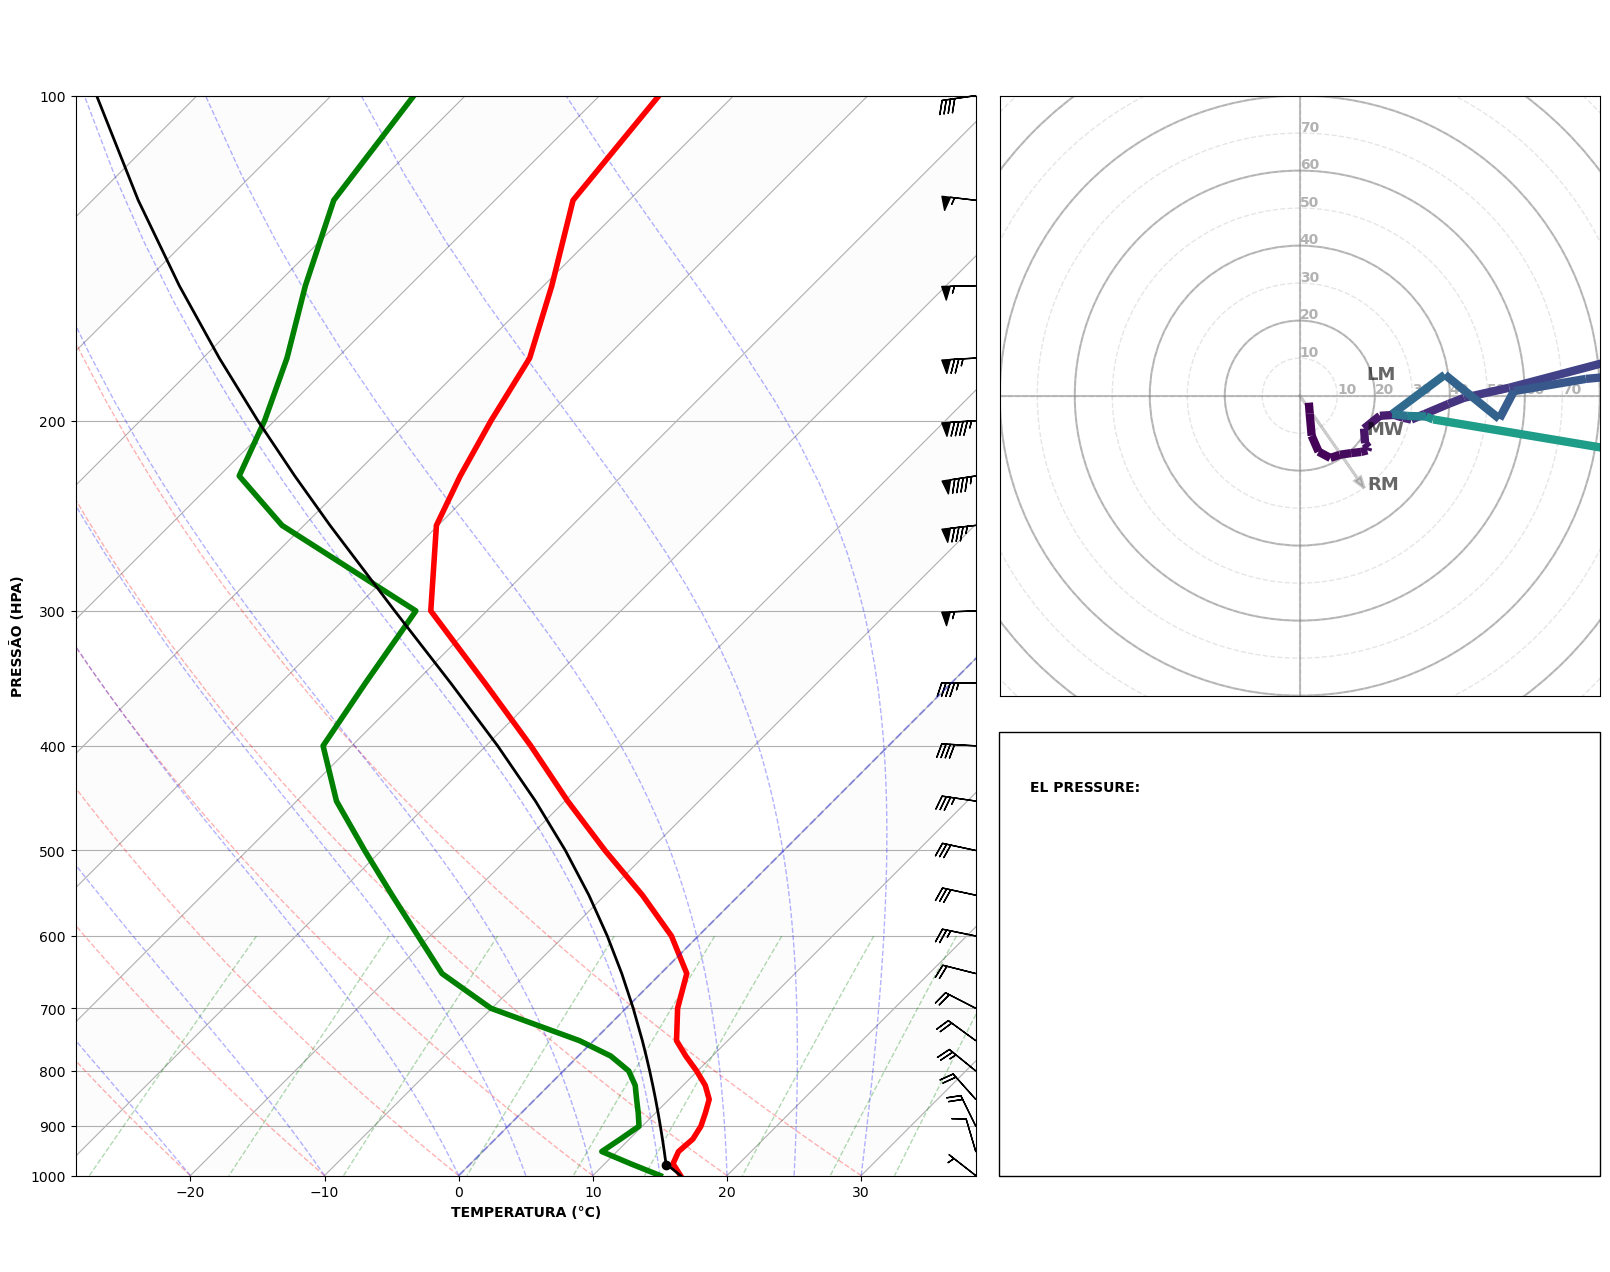

In [32]:
d = n-6
while d < n+4:
    hora = lt_data.time[d].values
    hora = str(hora)
    hora = hora[0:13]
    
    T = (lt_data.t[d,:,la,lo].values-273.15)
    r = (lt_data.r[d,:,la,lo].values)
    td = T - ((100 - r)/5)
    p = lt_data.level.values
    u = (lt_data.u[d,:,la,lo].values*1.944)
    v = (lt_data.v[d,:,la,lo].values*1.944)
    z  = (lt_data.z[d,:,la,lo].values/9.80665)
    
    z = list(reversed(z)) * units.meters
    r = list(reversed(r)) *units.percent
    p = list(reversed(p)) * units.hPa
    T = list(reversed(T)) * units.degC
    Td = list(reversed(td)) * units.degC
    u = list(reversed(u)) * units.knots
    v = list(reversed(v)) * units.knots
    '''
        STEP 1: CREATE THE SKEW-T OBJECT AND MODIFY IT TO CREATE A NICE, CLEAN PLOT
    '''
    
    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(18,12))
    skew = SkewT(fig, rotation=45, rect=(0, 0, 0.50, 0.90))
    
    # Change to adjust data limits and give it a semblance of what we want
    skew.ax.set_adjustable('datalim')
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-20, 30)
    
    # Set some better labels than the default to increase readability
    skew.ax.set_xlabel(str.upper(f'Temperatura ({T.units:~P})'), weight='bold')
    skew.ax.set_ylabel(str.upper(f'Pressão ({p.units:~P})'), weight='bold')
    
    # Set the facecolor of the Skew Object and the Figure to white
    fig.set_facecolor('#ffffff')
    skew.ax.set_facecolor('#ffffff')
    
    # Here we can use some basic math and python functionality to make a cool
    # shaded isotherm pattern.
    x1 = np.linspace(-100, 40, 8)
    x2 = np.linspace(-90, 50, 8)
    y = [1100, 50]
    for i in range(0, 8):
        skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)
    
    '''
        STEP 2: PLOT DATA ON THE SKEW-T. TAKE A COUPLE EXTRA STEPS TO INCREASE READABILITY
    '''
    
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plotm
    # set the linewidth to 4 for increased readability.
    # We will also add the 'label' kew word argument for our legend.
    skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
    skew.plot(p, Td, 'g', lw=4, label='PONTO DE ORVALHO')
    
    # again we can use some simple python math functionality to 'resample'
    # the wind barbs for a cleaner output with increased readability.
    # Something like this would work.
    interval = np.logspace(2, 3, 40) * units.hPa
    idx = mpcalc.resample_nn_1d(p, interval)
    skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx], flip_barb=True)
    
    # Add the relevant special lines native to the Skew-T Log-P diagram &
    # provide basic adjustments to linewidth and alpha to increase readability
    # first we add a matplotlib axvline to highlight the 0 degree isotherm
    skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
    skew.plot_dry_adiabats(lw=1, alpha=0.3)
    skew.plot_moist_adiabats(lw=1, alpha=0.3)
    skew.plot_mixing_lines(lw=1, alpha=0.3)
    
    # Calculate LCL height and plot as black dot. Because `p`'s first value is
    # ~1000 mb and its last value is ~250 mb, the `0` index is selected for
    # `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
    # i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
    # should be selected.
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
    
    # Calculate full parcel profile and add to plot as black line
    prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    skew.plot(p, prof, 'k', linewidth=2,)
    
    # Shade areas of CAPE and CIN
    skew.shade_cin(p, T, prof, Td, alpha=0.2, label='CIN')
    skew.shade_cape(p, T, prof, alpha=0.2, label='CAPE')
    
    
    
    '''
        STEP 3: CREATE THE HODOGRAPH INSET. TAKE A FEW EXTRA STEPS TO INCREASE READABILITY
    '''
    
    # Create a hodograph object: first we need to add an axis
    # then we can create the metpy Hodograph
    hodo_ax = plt.axes((0.43, 0.40, 0.5, 0.5))
    h = Hodograph(hodo_ax, component_range=80.)
    # Add two seperate grid increments for a cooler look. This also
    # helps to increase readability
    h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
    h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
    # The next few steps makes for a clean hodograph inset, removing the
    # tick marks, tick labels and axis labels
    h.ax.set_box_aspect(1)
    h.ax.set_yticklabels([])
    h.ax.set_xticklabels([])
    h.ax.set_xticks([])
    h.ax.set_yticks([])
    h.ax.set_xlabel(' ')
    h.ax.set_ylabel(' ')
    
    # Here we can add a simple python for loop that adds tick marks to the inside
    # of the hodograph plot to increase readability!
    plt.xticks(np.arange(0,0,1))
    plt.yticks(np.arange(0,0,1))
    for i in range(10,120,10):
        h.ax.annotate(str(i),(i,0),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=10,weight='bold',alpha=0.3,zorder=0)
    for i in range(10,120,10):
        h.ax.annotate(str(i),(0,i),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=10,weight='bold',alpha=0.3,zorder=0)
    
    # plot the hodograph itself, using plot_colormapped, colored
    # by height
    h.plot_colormapped(u, v, c=z, linewidth=6, label="0-12km VENTO")
    # compute Bunkers storm motion so we can plot it on the hodograph!
    RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
    h.ax.text((RM[0].m +0.5), (RM[1].m -0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
    h.ax.text((LM[0].m +0.5), (LM[1].m -0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
    h.ax.text((MW[0].m +0.5), (MW[1].m -0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
    h.ax.arrow(0,0,RM[0].m-0.3, RM[1].m-0.3, linewidth=2, color='black', alpha=0.2, label='vetor de Bunkers RM',
              length_includes_head=True, head_width=2)
    
    
    
    '''
        STEP 4: ADD A FEW EXTRA ELEMENTS TO REALLY MAKE A NEAT PLOT
    '''
    # First we want to actually add values of data to the plot for easy viewing
    # to do this, lets first add a simple rectangle using matplotlib's 'patches'
    # fucntionality to add some simple layout for plotting calculated parameters
    #                                  xloc   yloc   xsize  ysize
    fig.patches.extend([plt.Rectangle((0.513, 0.00), 0.334, 0.37,
                                      edgecolor='black', facecolor='white', linewidth=1, alpha=1,
                                      transform=fig.transFigure, figure=fig)])
    
    # now lets take a moment to calculate some simple severe-weather parameters using
    # metpy's calculations 
    # here are some classic severe parameters!
    kindex = mpcalc.k_index(p, T, Td)
    total_totals = mpcalc.total_totals_index(p, T, Td)
    
    # mixed layer parcel properties!
    ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
    ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, prof, depth=50 * units.hPa)
    
    # most unstable parcel properties!
    mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
    mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td)
    
    # Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
    new_p = np.append(p[p > lcl_pressure], lcl_pressure)
    new_t = np.append(T[p > lcl_pressure], lcl_temperature)
    lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)
    
    # Compute Surface-based CAPE
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
    
    # Compute SRH 
    (u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
    *_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                        storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km,
                                                        storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km,
                                                        storm_u=u_storm, storm_v=v_storm)
    
    # Copmute Bulk Shear components and then magnitude
    ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
    bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
    ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
    bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
    ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
    bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
    
    # Use all computed pieces to calculate the Significant Tornado parameter
    sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                         total_helicity3, bshear3).to_base_units()
    
    # Perform the calculation of supercell composite if an effective layer exists
    super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)


    *_, total_helicity = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                    storm_u=u_storm, storm_v=v_storm)
    
    ctotals = mpcalc.cross_totals(p, T, Td)
    kindex = mpcalc.k_index(p, T, Td)
    showalter = mpcalc.showalter_index(p, T, Td)
    total_totals = mpcalc.total_totals_index(p, T, Td)
    vert_totals = mpcalc.vertical_totals(p, T)
    el_pressure, _ = mpcalc.el(p, T, Td, prof)
    lift_index = mpcalc.lifted_index(p, T, prof)
    lclp, lclt = mpcalc.lcl(p[0], T[0], Td[0])
    lfcp, _ = mpcalc.lfc(p, T, Td)
    cape, cin = mpcalc.cape_cin(p, T, Td, prof)
    ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
    ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, prof, depth=50 * units.hPa)
    mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
    mucape1, mucin1 = mpcalc.most_unstable_cape_cin(p, T, Td)
    
    plt.figtext( 0.53, 0.32,  f'EL PRESSURE: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.66, 0.32,  f'{int(el_pressure.m)} Hpa', weight='bold', fontsize=10, color='navy', ha='right')
    plt.figtext( 0.53, 0.29,  f'LIFT INDEX: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.66, 0.29,  f'{int(lift_index.m)}', weight='bold', fontsize=10, color='orangered', ha='right')
    
    plt.figtext( 0.53, 0.24,  f'MUCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.66, 0.24,  f'{int(mucape1.m)} J/kg', weight='bold', fontsize=10, color='orangered', ha='right')
    plt.figtext( 0.53, 0.21,  f'MUCIN: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.66, 0.21,  f'{int(mucin1.m)} J/kg', weight='bold', fontsize=10, color='blue', ha='right')
    
    plt.figtext( 0.53, 0.16,  f'CAPE: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.66, 0.16,  f'{int(cape.m)} J/kg', weight='bold', fontsize=10, color='orangered', ha='right')
    plt.figtext( 0.53, 0.13,  f'CIN: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.66, 0.13,  f'{int(cin.m)} J/kg', weight='bold', fontsize=10, color='blue', ha='right')
    
    plt.figtext( 0.53, 0.08,  f'TT-INDEX: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.66, 0.08,  f'{int(total_totals.m)} Δ°C', weight='bold', fontsize=10, color='orangered', ha='right')
    plt.figtext( 0.53, 0.05,  f'K-INDEX: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.66, 0.05,  f'{int(kindex.m)} °C', weight='bold', fontsize=10, color='orangered', ha='right')
    
    # now some kinematic parameters
    met_per_sec = (units.m*units.m)/(units.sec*units.sec)
    plt.figtext( 0.68, 0.32,  f'LCL Pressure: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.83, 0.32,  f'{int(lclp.m)} Hpa', weight='bold', fontsize=10, color='navy', ha='right')
    plt.figtext( 0.68, 0.29,  f'LFC Pressure: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.83, 0.29,  f'{int(lfcp.m)} Hpa', weight='bold', fontsize=10, color='navy', ha='right')
    
    plt.figtext( 0.68, 0.24,  f'SHOWALTER-INDEX: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.83, 0.24,  f'{int(showalter.m)}', weight='bold', fontsize=10, color='navy', ha='right')
    plt.figtext( 0.68, 0.21,  f'VERTICAL TOTALS: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.83, 0.21,  f'{int(vert_totals.m) } Δ°C', weight='bold', fontsize=10, color='blue', ha='right')
    
    plt.figtext( 0.68, 0.16,  f'0-6km SRH: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.83, 0.16,  f'{int(total_helicity6.m)* met_per_sec:~P}', weight='bold', fontsize=10, color='navy', ha='right')
    plt.figtext( 0.68, 0.13,  f'0-6km SHEAR: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.83, 0.13,  f'{int(bshear6.m)} kts', weight='bold', fontsize=10, color='blue', ha='right')
    
    plt.figtext( 0.68, 0.08,  f'HELIOCIDADE: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.83, 0.08,  f'{int(total_helicity.m)* met_per_sec:~P}', weight='bold', fontsize=10, color='navy', ha='right')
    plt.figtext( 0.68, 0.05,  f'SUPERCELL COMP: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext( 0.83, 0.05,  f'{int(super_comp.m)}', weight='bold', fontsize=10, color='orangered', ha='right')
    
    # add legends to the skew and hodo
    skewleg = skew.ax.legend(loc='upper left')
    hodoleg = h.ax.legend(loc='upper left')
    
    # add a plot title
    plt.figtext( 0.40, 0.92,  f'Skew-T | {local} {hora}', weight='bold', fontsize=20, ha='center')
    fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\skewt{d}.png', bbox_inches='tight')
    d = d+1

In [34]:
c=0
for i in tempo:
    tempo[c] = tempo[c].tolist()
    c = c+1
c=0 
lift2= []
for i in lift:
    lift2.append(lift[c][0].magnitude)
    c=c+1
c=0
d=0
mucape2= []
for i in mucapee:
    d = 0
    while d<= 1: 
        if d/2 == 0:
            mucape2.append(mucapee[c][d].magnitude)
            d=d+1
        else:
            d=d+1
    c = c+1

    
fig = plt.figure(figsize=(10,3))
plt.bar(tempo,pw, width = 0.5,color="c" ,align= 'center')
plt.ylim(top=100, bottom=0)
plt.title(f" Água preciptável,{local}")
plt.ylabel('milimetros - mm ')
plt.xlabel('tempo - horas')
plt.show()
fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\awa.png', bbox_inches='tight')

fig = plt.figure(figsize=(10,3))
plt.bar(tempo, lift2, width = 0.5,color="orange" ,align= 'center')
plt.ylim(top=1, bottom=-8)
plt.title(f"Lift index,{local}")
plt.ylabel('lift index')
plt.xlabel('tempo - horas')
plt.show()
fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\lift.png', bbox_inches='tight')

fig = plt.figure(figsize=(10,3))
plt.bar(tempo,mucape2, width = 0.5,color="g" ,align= 'center')
plt.ylim(top=1000, bottom=0)
plt.title(f"Most Unstable CAPE,{local}")
plt.ylabel('Mucape - j/kg')
plt.xlabel('tempo - horas')
plt.show()
fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\mucape.png', bbox_inches='tight')

AttributeError: 'str' object has no attribute 'tolist'

In [51]:
################1º a ser rodada
mu1=  mucape2
pw1 = pw
li1 = lift2
data1 = hora[0:10]


In [65]:
################2º a ser rodada
mu2=  mucape2
pw2 = pw
li2 = lift2
data2 = hora[0:10]


In [120]:
################3º a ser rodada
mu3=  mucape2
pw3 = pw
li3 = lift2
data3 = hora[0:10]


In [114]:
################4º a ser rodada
mu4=  mucape2
pw4 = pw
li4 = lift2
data4= hora[0:10]


In [106]:
################5º a ser rodada
mu5=  mucape2
pw5 = pw
li5 = lift2
data5 = hora[0:10]


In [107]:
pw5

[42.151045795984,
 40.12483405468077,
 38.01593904848111,
 36.778313165777845,
 38.706178042871805,
 43.07837259170969,
 48.044078048436674,
 44.94991964264912,
 42.445143349033046,
 41.19866154926666]

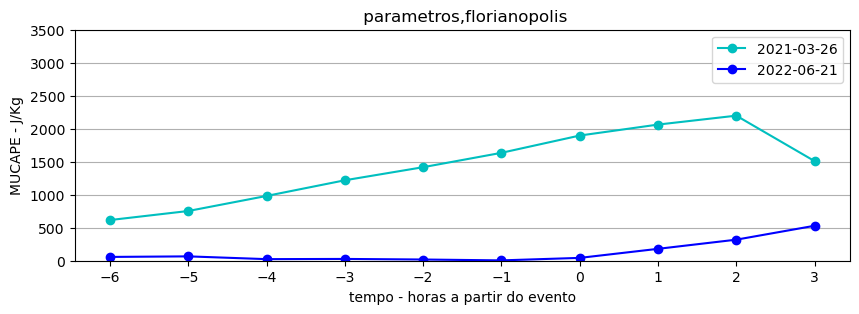

In [68]:
tempo = [-6, -5 , -4, -3, -2, -1, 0,1,2,3]
fig = plt.figure(figsize=(10,3))
plt.plot(tempo,mu1, 'o-',color="c" , label= f"{data1}")
plt.plot(tempo,mu2, 'o-',color="b" , label= f"{data2}")
#plt.plot(tempo,mu3, 'o-',color="g" , label= f"{data3}")
#plt.plot(tempo,mu4, 'o-',color="y" , label= f"{data4}")
#plt.plot(tempo,mu5, 'o-',color="r" , label= f"{data5}")
plt.ylim(top=3500, bottom=0)
plt.title(f" parametros,{local}")
plt.xlabel('tempo - horas a partir do evento')
plt.ylabel('MUCAPE - J/Kg')
plt.legend(loc='upper right')
plt.grid(axis = 'y')
plt.xticks(tempo)

plt.show()
fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\mucapecomparativo.png', bbox_inches='tight')

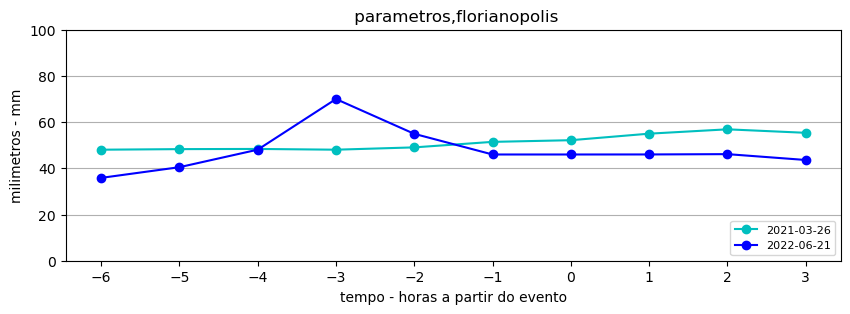

In [67]:
tempo = [-6, -5 , -4, -3, -2, -1, 0,1,2,3]
fig = plt.figure(figsize=(10,3))
plt.plot(tempo,pw1, 'o-',color="c" , label= f"{data1}")
plt.plot(tempo,pw2, 'o-',color="b" , label= f"{data2}")
#plt.plot(tempo,pw3, 'o-',color="g" , label= f"{data3}")
#plt.plot(tempo,pw4, 'o-',color="y" , label= f"{data4}")
#plt.plot(tempo,pw5, 'o-',color="r" , label= f"{data5}")
plt.ylim(top=100, bottom=0)
plt.title(f" parametros,{local}")
plt.xlabel('tempo - horas a partir do evento')
plt.ylabel('milimetros - mm')
plt.legend(loc='lower right',fontsize = 8)
plt.grid(axis = 'y')
plt.xticks(tempo)

plt.show()
fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\pwcomparativo.png', bbox_inches='tight')

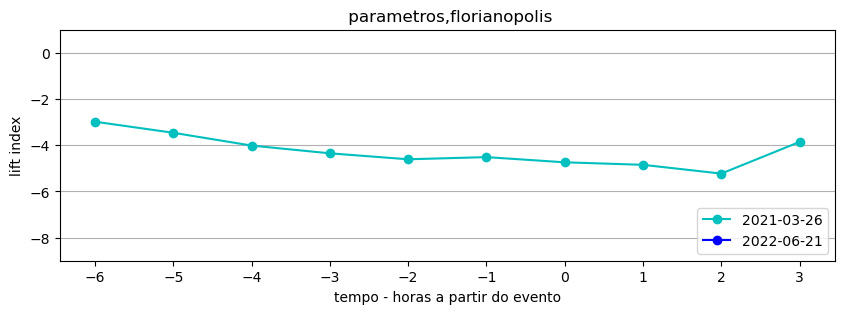

In [69]:
tempo = [-6, -5 , -4, -3, -2, -1, 0,1,2,3]
fig = plt.figure(figsize=(10,3))
plt.plot(tempo,li1, 'o-',color="c" , label= f"{data1}")
plt.plot(tempo,li2, 'o-',color="b" , label= f"{data2}")
#plt.plot(tempo,li3, 'o-',color="g" , label= f"{data3}")
#plt.plot(tempo,li4, 'o-',color="y" , label= f"{data4}")
#plt.plot(tempo,li5, 'o-',color="r" , label= f"{data5}")
plt.ylim(top=1, bottom=-9)
plt.title(f" parametros,{local}")
plt.xlabel('tempo - horas a partir do evento')
plt.ylabel('lift index')
plt.legend(loc='lower right')
plt.grid(axis = 'y')
plt.xticks(tempo)

plt.show()
fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\liftcomparativo.png', bbox_inches='tight')